# FEUP - AC
## Banking - Predicting a Loan Outcome

### Business understanding

##### Analysis of requirements with the end user
Text

##### Definition of business goals
Text

##### Translation of business goals into data mining goals
Text

### Exploratory data analysis

Let us start by importing the datasets.

In [38]:
import pandas as pd
import numpy as np

DATA_SOURCE = 'data/'

# Read in the data
accounts = pd.read_csv(DATA_SOURCE + 'account.csv', sep=';')
cards = pd.read_csv(DATA_SOURCE + 'card_dev.csv', sep=';')
clients = pd.read_csv(DATA_SOURCE + 'client.csv', sep=';')
dispositions = pd.read_csv(DATA_SOURCE + 'disp.csv', sep=';')
districts = pd.read_csv(DATA_SOURCE + 'district.csv', sep=';')
loans = pd.read_csv(DATA_SOURCE + 'loan_dev.csv', sep=';')
transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')

loans.head()

/tmp/ipykernel_19358/1512161642.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions = pd.read_csv(DATA_SOURCE + 'trans_dev.csv', sep=';')


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


Plenty of analysis with graphs, distributions, outliers...

### Data preprocessing

Text

#### Processing accounts

The account spreadsheet relates it with the district and date in which it was created, as well with the frequency of issuance of statements with the owner.

The date comes in the from YYMMDD, which is easily extractable to the three different columns that it is aggregating. This will aid the model in detecting important patterns in the year of creation, for example, indicating a global economic crisis or prosperity when the person has created the account.

In [39]:
import src.preprocess.accounts as accpp
accounts = accpp.preprocess_accounts(accounts)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day
0,576,55,monthly issuance,93,1,1
1,3818,74,monthly issuance,93,1,1
2,704,55,monthly issuance,93,1,1
3,2378,16,monthly issuance,93,1,1
4,2632,24,monthly issuance,93,1,2


#### Processing credit cards

In the credit cards relation, the same concept applies to the date of issuance. The type is an enumeration and the other two columns are references which are not treatable at this stage.

In [40]:
from src.preprocess.cards import preprocess_cards

cards = preprocess_cards(cards)
cards.head()

,card_id,disp_id,type,year,month,day
0,1005,9285,classic,93,11,7
1,104,588,classic,94,1,19
2,747,4915,classic,94,2,5
3,70,439,classic,94,2,8
4,577,3687,classic,94,2,15


#### Processing clients

In the clients relation, two foreign references and a date appear once again. However, regarding the latter one, there is an important difference: the day is the actual day plus fifty, if the client is a female, and so we can extract the gender too, here.

In [41]:
from src.preprocess.clients import preprocess_clients

clients = preprocess_clients(clients)
clients.head()

,client_id,district_id,year,month,day,gender
0,1,18,70,12,13,female
1,2,1,45,2,4,male
2,3,1,40,10,9,female
3,4,5,56,12,1,male
4,5,5,60,7,3,female


#### Processing dispositions

The disposition describes the rights of clients to operate accounts: only "owners" can ask for loans and issue permanent orders.

There is no clear way to merge this table with loans later on, since the loans table does not refer the disposition used for the loan. Instead, let's focus on the number of dispositions and the ratio of owners of an account, which will give an impression of the nature of the people able to control the account. All humans fight and cheat on each other, or build trust together. Let's discover that pattern in Czech Republic.

In [42]:
from src.preprocess.dispositions import preprocess_dispositions
dispositions = preprocess_dispositions(dispositions)
dispositions.head()

,disp_id,client_id,account_id,type,number_account_dispositions,number_account_disponents
0,1,1,1,OWNER,1,0
1,2,2,2,OWNER,2,1
2,3,3,2,DISPONENT,2,1
3,4,4,3,OWNER,2,1
4,5,5,3,DISPONENT,2,1


#### Processing districts

The districts relation is quite dense, describing the demographic data of a region. We can extract interesting measures here:

- The commited crimes growth ratio, derived from the evolution of the number of crimes from '95 to '96
- The unemployment rate growth ratio, derived from the evolution of the employment rate from '95 to '96

We also acknowledged that there was one region where the number of crimes and unemployment rate in '95 was not known (`?` was the appearance in the respective column). In order not to discard the entire region data, we'll simply assume that number to be the same as the matching record in '96.

In [43]:
from src.preprocess.districts import preprocess_districts
districts = preprocess_districts(districts)
districts.head()

,district_id,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,1,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
1,2,88884,5,46.7,8507,1.85,0.132,0.030084,1.238536,1.107784
2,3,75232,5,41.7,8980,2.21,0.111,0.037391,0.996105,1.133333
3,4,149893,6,67.4,9753,5.05,0.109,0.039308,1.123570,1.088362
4,5,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


#### Processing loans

The loans relation references an account and the date of loan, which can be extracted. The duration seems to be in months, so let us improve the name of the column. The amounts seems to be in `Czech korunas`, the czech currency, as hinted by the list of regions; we'll convert it to euros for better visualization and understanding of the upcoming results. The status, which we want to predict, is either `1` for regular status of `-1` for debt; let us translate it to a string for clarity.

In [44]:
from src.preprocess.loans import preprocess_loans
loans = preprocess_loans(loans)
loans.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day
0,5314,1787,3950.66,12,329.22,-1,93,7,5
1,5316,1801,6801.64,36,188.93,1,93,7,11
2,6863,9188,5208.20,60,86.80,1,93,7,28
3,5325,1843,4336.23,36,120.45,1,93,8,3
4,7240,11013,11259.84,60,187.66,1,93,9,6


#### Processing `trans_dev.csv`

This table contains a lot of information that we cannot directly relate to a loan.

Let us first extract the date and make the withdrawal amounts actually negative, to give the model an impression of the direction of the money flow in and out of the bank.

For now, let us extract some statistical data related to the accounts, which we'll relate to the loans table.

In [45]:
from src.preprocess.transactions import preprocess_transactions
transactions = preprocess_transactions(transactions)
transactions.head()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day
0,1548749,5270,credit,credit in cash,32.79,32.79,NaN,NaN,NaN,93,1,13
1,1548750,5270,credit,collection from another bank,1833.98,1866.76,NaN,IJ,80269753.0,93,1,14
2,3393738,11265,credit,credit in cash,40.98,40.98,NaN,NaN,NaN,93,1,14
3,3122924,10364,credit,credit in cash,45.08,45.08,NaN,NaN,NaN,93,1,17
4,1121963,3834,credit,credit in cash,28.69,28.69,NaN,NaN,NaN,93,1,19


### Statistics

##### Average salary per district

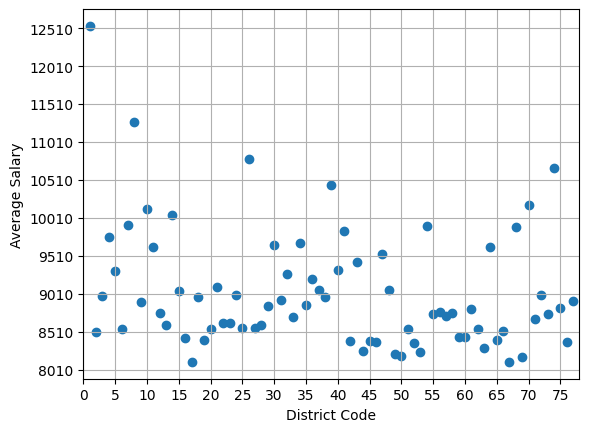

In [46]:
import src.stats.graphs as graphs
graphs.plot_salary_per_district(districts)

##### Card type distribution

   card_id  disp_id     type  year  month  day
0     1005     9285  classic    93     11    7
1      104      588  classic    94      1   19
2      747     4915  classic    94      2    5
3       70      439  classic    94      2    8
4      577     3687  classic    94      2   15


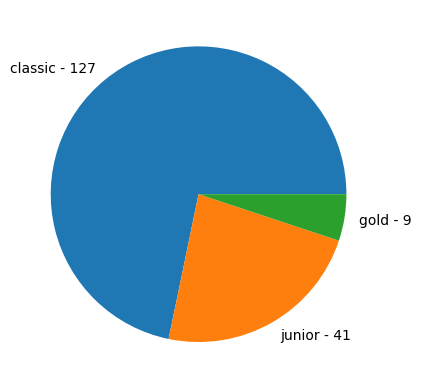

In [47]:
graphs.plot_card_type_distribution(cards)

##### Gender distribution

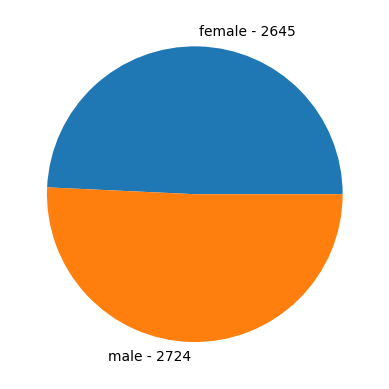

In [48]:
graphs.plot_gender_distribution(clients)

##### Loans stats

[-1  1]


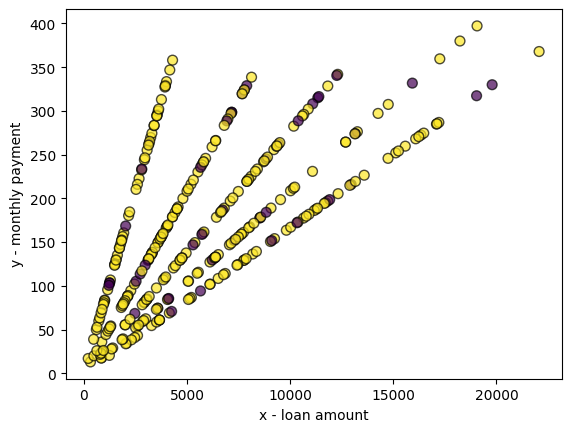

In [49]:
graphs.plot_monthly_payment_per_loan_amount(loans)

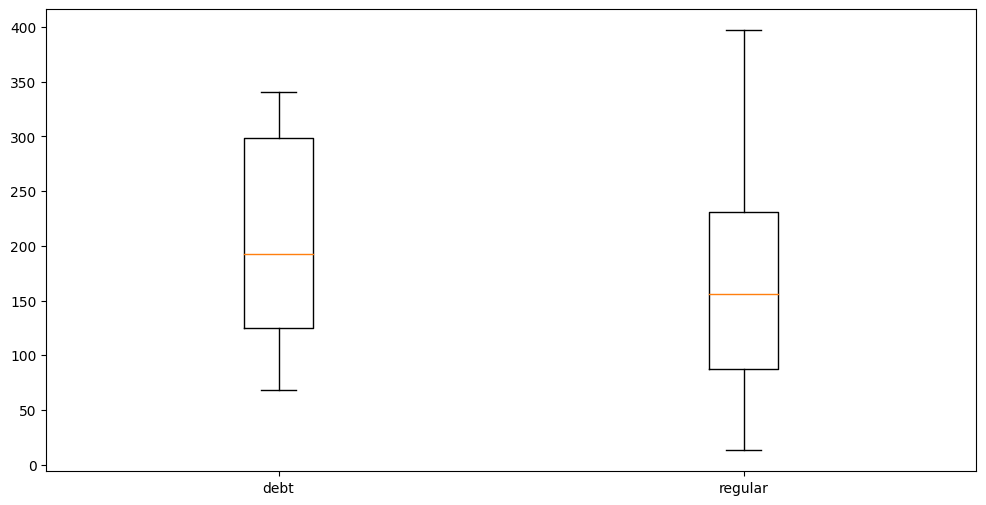

In [50]:
graphs.plot_monthly_payment_per_status(loans)

#### Merging the data

The model will be working on the `loans` table, since the target variable belongs to it. The one foreign key of that table is `account_id`; so, to feed the model with more information about the context of the loan, we should relate concepts to the account for each table.

##### Relating cards to accounts

In [51]:
import src.feature_engineering.merge as merge
cards = merge.merge_card_account(cards, dispositions)
cards.head()

,card_id,disp_id,card_type,card_year,card_month,card_day,account_id
0,1005,9285,classic,93,11,7,7753
1,104,588,classic,94,1,19,489
2,747,4915,classic,94,2,5,4078
3,70,439,classic,94,2,8,361
4,577,3687,classic,94,2,15,3050


##### Relating accounts with district data

Text

In [52]:
accounts = accounts.merge(districts, on="district_id").drop(axis=1, columns=["district_id"])
accounts.head()

,account_id,account_frequency,account_year,account_month,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,576,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
1,704,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
2,192,monthly issuance,93,1,8,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
3,10364,monthly issuance,93,1,17,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553
4,497,monthly issuance,93,4,15,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553


##### Loading the loans table with data

In [53]:
accounts = accounts.rename(columns = {'year':'account_year', 'month':'account_month', 'day':'account_day', 'frequency': 'account_frequency', 'district_id': 'account_district_id'})
loans = loans.merge(accounts, on="account_id")
loans.head()

# merge with disp with card
# merge disp with account
# merge stuff

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day,account_frequency,...,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,5314,1787,3950.66,12,329.22,-1,93,7,5,weekly issuance,...,22,94812,10,81.8,9650,3.67,0.100,0.029574,0.939363,1.085799
1,5316,1801,6801.64,36,188.93,1,93,7,11,monthly issuance,...,13,112709,10,73.5,8369,2.31,0.117,0.023228,0.917309,1.290503
2,6863,9188,5208.20,60,86.80,1,93,7,28,monthly issuance,...,8,77917,5,53.5,8390,2.89,0.132,0.027234,1.020192,1.267544
3,5325,1843,4336.23,36,120.45,1,93,8,3,monthly issuance,...,30,107870,6,58.0,8754,4.31,0.137,0.035858,1.016824,1.125326
4,7240,11013,11259.84,60,187.66,1,93,9,6,weekly issuance,...,14,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759


#### Feature engineering

Text

##### Getting the average account balance based on the transactions

In [55]:
from src.feature_engineering.merge import merge_account_transactions
accounts = merge_account_transactions(accounts, transactions)
accounts.head()

,account_id,account_frequency,account_year,account_month,account_day,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth,account_average_balance_x,account_average_balance_y
0,576,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,995.213406,995.213406
1,704,monthly issuance,93,1,1,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1424.108906,1424.108906
2,192,monthly issuance,93,1,8,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1019.869554,1019.869554
3,10364,monthly issuance,93,1,17,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,1404.598889,1404.598889
4,497,monthly issuance,93,4,15,157042,9,33.9,8743,2.43,0.111,0.024796,1.064225,1.292553,2244.168398,2244.168398


In [56]:
# extract more columns

### Training the model

Text

In [57]:
# extract categorical values here later...
loans_tmp = loans.drop(axis=1, columns=["account_frequency"])

for col in loans_tmp.columns:
    print(col)

loan_id
account_id
amount
duration_months
monthly_payment
status
year
month
day
account_year
account_month
account_day
district_no_inhabitants
district_no_cities
district_urban_inhabitants_ratio
district_average_salary
district_unemployment_rate
districts_entrepreneurs_ratio
district_crimes_per_inhabitant
district_crime_growth
district_unemploymant_growth


#### Splitting the data for training

Text

In [58]:
from sklearn.model_selection import train_test_split

target = loans_tmp.status.values
independent = loans_tmp.drop('status', axis=1).values

# Make sure to split by future date later...
x_train, x_test, y_train, y_test = train_test_split(
        independent, target, test_size=0.2, random_state=0)

#### Feeding the model

Evaluate classification model performance with loans table

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, accuracy_score

# Create a Random Forest Model
random_classifier = RandomForestClassifier(
    n_estimators=10)

# Train it with data
random_classifier.fit(x_train, y_train)

# Predict the test data
predictions = random_classifier.predict(x_test)

print(predictions)

# Check the accuracy
print(recall_score(y_test, predictions, pos_label=-1))
print(accuracy_score(y_test, predictions))

[-1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1]
0.18181818181818182
0.8181818181818182


### Evaluating the model

Text